# Task 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw

Epoch: 0
Mean Train Loss: 3.97e-01
Mean Test Loss:  2.85e-01
Epoch: 10
Mean Train Loss: 1.43e-01
Mean Test Loss:  3.15e-01
Epoch: 20
Mean Train Loss: 1.11e-01
Mean Test Loss:  3.87e-01
Epoch: 30
Mean Train Loss: 6.90e-02
Mean Test Loss:  5.41e-01
Epoch: 40
Mean Train Loss: 3.85e-02
Mean Test Loss:  6.33e-01
Epoch: 50
Mean Train Loss: 4.01e-02
Mean Test Loss:  8.10e-01
Epoch: 60
Mean Train Loss: 2.89e-02
Mean Test Loss:  9.29e-01
Epoch: 70
Mean Train Loss: 2.05e-02
Mean Test Loss:  7.80e-01
Epoch: 80
Mean Train Loss: 1.15e-02
Mean Test Loss:  7.84e-01
Epoch: 90
Mean Train Loss: 1.90e-02
Mean Test Loss:  1.11e+00
Epoch: 100
Mean Train Loss: 1.90e-02
Mean Test Loss:  8.61e-01


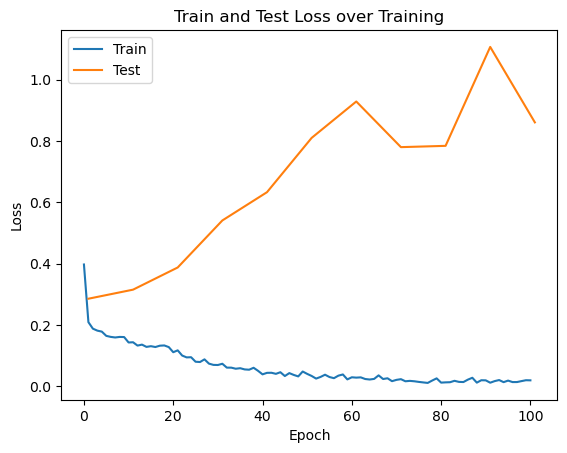

In [1]:
import numpy as np
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold;">
The code is not divided into different cells but have reused the code in the Task2. The running of the given model and the result seems in accordance with the given solution.
</div>

# Task 2

Epoch: 0
Mean Train Loss: 1.03e+00
Mean Test Loss:  7.14e-01
Epoch: 10
Mean Train Loss: 1.00e+00
Mean Test Loss:  1.04e+00
Epoch: 20
Mean Train Loss: 1.25e+00
Mean Test Loss:  1.26e+00
Epoch: 30
Mean Train Loss: 1.53e+00
Mean Test Loss:  1.49e+00
Epoch: 40
Mean Train Loss: 1.66e+00
Mean Test Loss:  1.71e+00
Epoch: 50
Mean Train Loss: 1.84e+00
Mean Test Loss:  1.96e+00
Epoch: 60
Mean Train Loss: 1.85e+00
Mean Test Loss:  1.88e+00
Epoch: 70
Mean Train Loss: 2.00e+00
Mean Test Loss:  2.72e+00
Epoch: 80
Mean Train Loss: 2.15e+00
Mean Test Loss:  2.08e+00
Epoch: 90
Mean Train Loss: 2.14e+00
Mean Test Loss:  2.03e+00
Epoch: 100
Mean Train Loss: 2.25e+00
Mean Test Loss:  2.50e+00


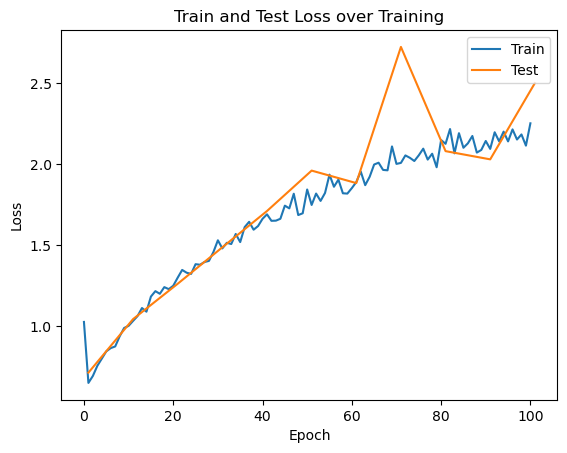

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


def Dropout(x, p_drop = 0.5):
    if p_drop >= 1 or p_drop <=0:
        return x
    else:
        mask = torch.bernoulli(torch.full_like(x, 1-p_drop))/(1-p_drop)
        return x * mask

# define the neural network
def model(x, w_h, w_h2, w_o):
    x = Dropout(x)
    h = rectify(x @ w_h)
    h = Dropout(h)
    
    h2 = rectify(h @ w_h2)
    h2 = Dropout(h2)
          
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


Dropout function works by randomly dropping out a certain percentage of the neurons in neural network layer during training. this means that at the rate of dropout given, the dropout function randomly calculates the probability of each neuron and sets it to zero. dropout function effectively reduces the interdependencies from the other neurons. 

<div style="color: green; font-weight: bold;">
The implementation of the dropout function and the model is in accordance with the given solution and correct. But, the input dropout rate and output dropout rate given differs from the given sample solution and hence the difference in the result of train and test loss rates.
</div>

<div style="color: green; font-weight: bold;">
The answer to the given question is answered correctly according to the sample solution
</div>

From the figure above we can see that the dropout function has improved as compared to the task 1

The below code uses different input dropout rate and hidden dropout rate. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


def Dropout(x, p_drop):
    if p_drop >= 1 or p_drop <=0:
        return x
    else:
        mask = torch.bernoulli(torch.full_like(x, 1-p_drop))/(1-p_drop)
        return x * mask

# define the neural network
def model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x = Dropout(x, p_drop_input)
    h = rectify(x @ w_h)
    h = Dropout(h, p_drop_hidden)
    
    h2 = rectify(h @ w_h2)
    h2 = Dropout(h2, p_drop_hidden)
          
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o, 0.2, 0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o, 0.2, 0.5)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


Epoch: 0
Mean Train Loss: 7.29e-01
Mean Test Loss:  4.62e-01
Epoch: 10
Mean Train Loss: 6.60e-01


KeyboardInterrupt: 

<div style="color: green; font-weight: bold;">
Here we tried to implement the dropout function only with input droput rate of 0.2 and hidden dropout rate of 0.5 but could not complete the execution due to some problem in rerunning of the notebook. 
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

# Task 3: PRelu
For runtime purposes, we reduced the number of neurons per layer to 25 in both the sample and modified network. This naturally reduces the network's predictive power, but makes it much easier to adjust and test various network parameters.

First, we ran the provided sample code to get a base line for our comparison, resulting in the following loss spread over a total of 100 epochs:

Epoch: 0
Mean Train Loss: 5.56e-01
Mean Test Loss:  3.15e-01
Epoch: 10
Mean Train Loss: 1.59e-01
Mean Test Loss:  2.15e-01
Epoch: 20
Mean Train Loss: 1.32e-01
Mean Test Loss:  1.69e-01
Epoch: 30
Mean Train Loss: 1.23e-01
Mean Test Loss:  2.09e-01
Epoch: 40
Mean Train Loss: 1.20e-01
Mean Test Loss:  2.36e-01
Epoch: 50
Mean Train Loss: 1.25e-01
Mean Test Loss:  2.79e-01
Epoch: 60
Mean Train Loss: 1.21e-01
Mean Test Loss:  2.81e-01
Epoch: 70
Mean Train Loss: 1.24e-01
Mean Test Loss:  3.03e-01
Epoch: 80
Mean Train Loss: 1.27e-01
Mean Test Loss:  3.80e-01
Epoch: 90
Mean Train Loss: 1.28e-01
Mean Test Loss:  3.25e-01
Epoch: 100
Mean Train Loss: 1.27e-01
Mean Test Loss:  3.34e-01


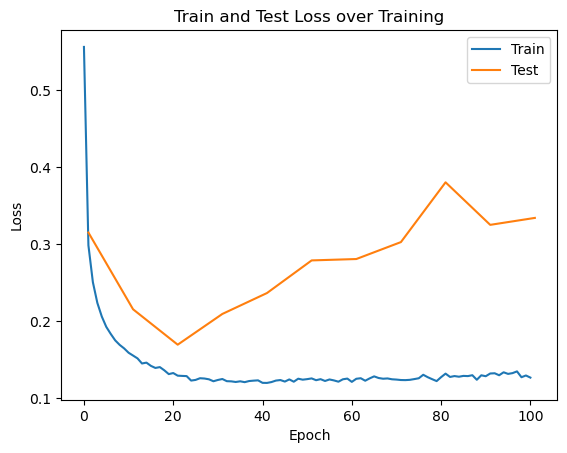

In [2]:
# Sample code
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax



# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 25))
# hidden layer with 625 neurons
w_h2 = init_weights((25, 25))
# hidden layer with 625 neurons
w_o = init_weights((25, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

As shown in the graph, the network quickly converges on a training mean loss of ~12% after approximately 20 epochs, and barely improves afterwards. On the contrary, the network even starts to severly overfit at the same point, as the test set's mean loss shoots up almost linearly after 20 epochs, from approximately 17% at epoch 20 to 33% after 100 epochs.

For the PRelu implementation, we used the formula suggested in the paper written by Kaiming et al[1], and simply replaced both Relu layers with their respective PRelu counterparts.
For the initial weights, we tested multiple variants, including the initializations used by the original authors (`a = 0.25` and a gaussian distribution with mean 0), as well as the initialization function already used for the weights.
In our case, the results did not differ significantly between the two randomized alternatives, so we decided to stick with the weight initialization for simplicity.

Furthermore, Kaiming et al use a simple linear (In respect to the gradient) backpropagation for their alpha optimization.
The RMS optimizer already present in the sample code seemed to work fine on our test runs, so we decided to use this optimizer instead.

[1]: [https://arxiv.org/pdf/1502.01852.pdf]

<div style="color: green; font-weight: bold;">
The sample implementation of the PRelu layer using `torch.where` is probably more efficient than our approach using `max` and `min` modeled after the formula given in the paper, but yields the same results.

In terms of training results, the sample network outperforms our PRelu due to the broader network (625 neurons instead of 25 per layer) and the combination of both Dropout and PRelu instead of just PRelu.
</div>

Epoch: 0
Mean Train Loss: 6.47e-01
Mean Test Loss:  2.93e-01
Epoch: 10
Mean Train Loss: 1.45e-01
Mean Test Loss:  1.67e-01
Epoch: 20
Mean Train Loss: 1.10e-01
Mean Test Loss:  2.00e-01
Epoch: 30
Mean Train Loss: 9.05e-02
Mean Test Loss:  1.85e-01
Epoch: 40
Mean Train Loss: 7.95e-02
Mean Test Loss:  2.02e-01
Epoch: 50
Mean Train Loss: 7.13e-02
Mean Test Loss:  2.05e-01
Epoch: 60
Mean Train Loss: 6.38e-02
Mean Test Loss:  2.17e-01
Epoch: 70
Mean Train Loss: 5.56e-02
Mean Test Loss:  2.67e-01
Epoch: 80
Mean Train Loss: 5.54e-02
Mean Test Loss:  2.35e-01
Epoch: 90
Mean Train Loss: 4.99e-02
Mean Test Loss:  2.71e-01
Epoch: 100
Mean Train Loss: 4.85e-02
Mean Test Loss:  2.68e-01


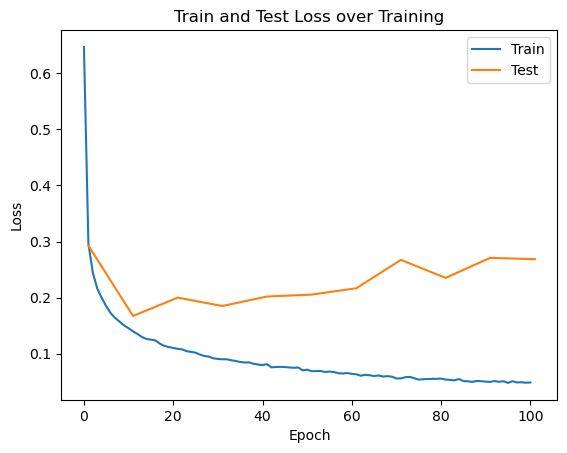

In [4]:
def PRelu(X, a):
    return torch.max(torch.zeros_like(X), X) + a * torch.min(torch.zeros_like(X), X)

plt.rc("figure", dpi=100)

# define the neural network
def Pmodel(x, w_h, a_h, w_h2, a_h2, w_o):
    h = PRelu(x @ w_h, a_h)
    h2 = PRelu(h @ w_h2, a_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights
# input shape is (B, 784)
w_h = init_weights((784, 25))
a_h = init_weights((1, 25))
# hidden layer with 625 neurons
w_h2 = init_weights((25, 25))
a_h2 = init_weights((1, 25))
# hidden layer with 625 neurons
w_o = init_weights((25, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_h, a_h2])
# prelu_optimizer = PReluprop(params=[a_h, a_h2])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = Pmodel(x, w_h, a_h, w_h2, a_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()
        # prelu_optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()
        # prelu_optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = Pmodel(x, w_h, a_h, w_h2, a_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The PRelu implementation clearly outperforms the Relu variant shown above in every regard, even with the simplifications explained above.
An implementation closer to the original paper probably only would have resulted in a slightly more noticable difference - as demonstrated in the paper, PRelu really shines for networks with a high number of layers, but less neurons per layer (In comparison to Relu) - it outperforms it even in less deep networks, but the difference seems to be less significant.

There are two major differences between PRelu and Relu: While both seem to converge on the training data in a similar manner, PRelu still has a noticable performance improvement past epoch 20 (Down to a mean train loss of 5%), while Relu stagnates almost entirely.
PRelu also converges significantly faster, reaching a mean training loss of 11% after only 10 epochs, while Relu is still at 16% at this point.

The second, even more significant difference can be found in the overfitting though: Similar to Relu, PRelu starts overfitting the network to the training data between 10 and 20 epochs (As seen in the increase of the mean test loss), but to a significantly lower extent:
The mean test loss in epoch 100 is approximately 27%, while Relu ends up at 33%.
Especially if compared to the mean train loss of PRelu (5%) versus PRelu (13%), these numbers clearly favor PRelu as the more superior activation function in every regard.

### 4 Convolutional layers (17 Points)


In this exercise, we want to create a similar neural network to LeNet by Yann LeCun. LeNet was designed for handwritten and machine-printed character recognition. It relies on convolutional layers that transform the input image by convolution with multiple learnable layers. LeNet contains convolutional layers paired with sub-sampling layers, as displayed in Figure 1. The subsampling is done via max pooling, which reduces an area of the image to one pixel with the maximum value of the area. Both functions are already available in PyTorch:
4.1
from torch.nn.functional import conv2d , max_pool2d
convolutional_layer = rectify(conv2d(previous_layer , weightvector)) # reduces (2,2) window to 1 pixel
subsampling_layer = max_pool_2d(convolutional_layer , out_layer = dropout(subsample_layer , p_drop_input)
Create a Convolutional network
(2, 2))
Now we can design our own convolutional neural network that classifies the handwritten numbers from MNIST.
Implementation task:
1. Make sure that the input image has the correct shape: trainX = trainX.reshape(-1, 1, 28, 28)#training data
testX = testX.reshape(-1, 1, 28, 28) #test data
2.Replace the first hidden layer h with 3 convolutional layers (including subsampling and dro- pout)
3. Connect the convolutional layers to the vectorized layer h2 by flattening the input with the torch.reshape.
4. The shape of the weight parameter for conv2d determines the number of filters f, the number of input images picin, and the kernel size k = (kx,ky). You can initialize the weights with
init_weights((f, pic_in, k_x, k_y))
Make  a neural network with :
$\begin{array}{|c|c|c|c|}
\hline
\text{convolutional layer} & \text{first} & \text{second} & \text{third} \\
\hline
f & 32 & 64 & 128 \\
\hline
\text{pic\{in\}} & 1 & 32 & 64 \\
\hline
k_x & 5 & 5 & 2 \\
\hline
k_y & 5 & 5 & 2 \\
\hline
\end{array}$

4.2 Application of Convolutional network 
- Task:
- Draw a sketch of the network (like Figure 1) and note the sizes of the lter images (This will help you to determine how many pixels there are in the last convolution layer).
- Train the model. Then, plot:
- one image from the test set
- its convolution with 3 filters of the first convolutional layer
- the corresponding filter weights (these should be 5 by 5 images).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Set random seed for reproducibility
torch.manual_seed(42)

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

# Get a batch of test images and labels
dataiter = iter(testloader)
images, labels = next(iter(testloader))

# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2)  # Third convolutional layer
        self.fc1 = nn.Linear(128 * 3 * 3, 625)  # Fully connected layer
        self.fc2 = nn.Linear(625, 10)  # Output layer

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # First convolutional layer with max pooling
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Second convolutional layer with max pooling
        x = F.relu(self.conv3(x))  # Third convolutional layer
        x = x.view(-1, 128 * 3 * 3)  # Flatten the input for fully connected layer
        x = F.relu(self.fc1(x))  # Rectified layer
        x = self.fc2(x)  # Pre-softmax output layer
        return x

# Creating an instance of LeNet
model = LeNet()

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:  # Print every 1000 mini-batches
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss/1000:.3f}')
            running_loss = 0.0

print('Training finished!')

# Plotting the results
fig, axs = plt.subplots(1, 4)
axs[0].imshow(images[0].squeeze(), cmap='gray')
axs[0].set_title('Original Image')

# Get the output of the first convolutional layer
conv1_output = model.conv1(images[0].unsqueeze(0))

# Get the filter weights of the first convolutional layer
filter_weights = model.conv1.weight

# Plotting the convolution with 3 filters of the first convolutional layer
for i in range(3):
    axs[i+1].imshow(conv1_output[0][i].detach(), cmap='gray')
    axs[i+1].set_title(f'Conv1 Filter {i+1}')

# Plotting the filter weights
fig, axs = plt.subplots(1, 3)
for i in range(3):
    axs[i].imshow(filter_weights[i][0].detach(), cmap='gray')
    axs[i].set_title(f'Filter Weight {i+1}')

plt.show()



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch: 1, Batch: 1000, Loss: 0.412
Epoch: 1, Batch: 2000, Loss: 0.171
Epoch: 1, Batch: 3000, Loss: 0.145
Epoch: 1, Batch: 4000, Loss: 0.114
Epoch: 1, Batch: 5000, Loss: 0.120
Epoch: 1, Batch: 6000, Loss: 0.115
Epoch: 1, Batch: 7000, Loss: 0.099
Epoch: 1, Batch: 8000, Loss: 0.109
Epoch: 1, Batch: 9000, Loss: 0.105
Epoch: 1, Batch: 10000, Loss: 0.072
Epoch: 1, Batch: 11000, Loss: 0.107
Epoch: 1, Batch: 12000, Loss: 0.094
Epoch: 1, Batch: 13000, Loss: 0.078
Epoch: 1, Batch: 14000, Loss: 0.088
Epoch: 1, Batch: 15000, Loss: 0.078
Epoch: 2, Batch: 1000, Loss: 0.054
Epoch: 2, Batch: 2000, Loss: 0.069
Epoch: 2, Batch: 3000, Loss: 0.081
Epoch: 2, Batch: 4000, Loss: 0.083
Epoch: 2, Batch: 5000, Loss: 0.067
Epoch: 2, Batch: 6000, Loss: 0.086
Epoch: 2, Batch: 7000, Loss: 0.076
Epoch: 2, Batch: 8000, Loss: 0.062
Epoch: 2, Batch: 9000, Loss: 0.068
Epoch: 2, Batch: 10000, Loss: 0.071
Epoch: 2, Batch: 11000, Loss: 0.074
Epoch: 

# Since this notebook had some issues please refer to the second notebook cnn2.ipynb file